In [7]:
import tensorflow as tf

In [8]:
@tf.function
def formula(x, y, b):
    x = tf.matmul(x, y)
    x = x + b
    return x


function_that_uses_a_graph = tf.function(formula) #  приймає у якості аргумента звичайну функцію і генерує обчислювальний граф

x1 = tf.constant([[1.0, 2.0]])
y1 = tf.constant([[2.0], [3.0]])
b1 = tf.constant(4.0)

orig_value = formula(x1, y1, b1).numpy()
tf_function_value = function_that_uses_a_graph(x1, y1, b1).numpy() # тензор, який буде перетворено на багатовимірний масив numpy

assert(orig_value == tf_function_value)

print(x1.shape)
print(y1.shape)
print(b1.shape)



(1, 2)
(2, 1)
()


# **для того, щоб отримати тензор маючи багатовимірний масив numpy достатньо виконати наступний код:**

In [9]:
import numpy as np
import tensorflow as tf


x_array = np.array([1, 2, 3])
x_tensor = tf.convert_to_tensor(x_array)



# **При цьому перетворення тензора на багатовимірний масив numpy виглядає ще простіше:**

In [10]:
x_tensor.numpy()


array([1, 2, 3])

# **Розглянемо ще один приклад. У нейронних мережах часто використовується активаційна функція ReLU: f(x)=max(x,0)**

In [11]:
import tensorflow as tf

@tf.function
def relu_activation(x):
    if tf.greater(x, 0):
        return x
    return 0

print(relu_activation(tf.constant(1)).numpy())
print(relu_activation(tf.constant(-1)).numpy())


1
0


# **Автоматичне диференціювання**

def f(x):
    return 1 / x ** 2

### ***обчислення градієнтів***

***Тепер похідну можна обчислити так:***

In [12]:
import tensorflow as tf


def f(x):
    return 1 / x ** 2


x = tf.Variable(2.0)
with tf.GradientTape() as tape:
    y = f(x)
    dydx = tape.gradient(y, x)
    print(dydx)


tf.Tensor(-0.25, shape=(), dtype=float32)


За допомогою класу GradientTape tensorflow записує всі операції, необхідні для обчислення похідної в змінну tape.

Для того, щоб ***обчислити значення похідної в конкретній точці***, потрібно ***викликати метод gradient***, приймає 2 аргументи. Перший - функція, похідну якої ми хочемо обчислити. Другий - аргумент, за яким обчислюється похідна (причому це може бути тензор). Цей механізм нам ще знадобиться далі.



# **Створення нейронної мережі**

***Нехай потрібно написати примітивну нейронну мережу, яка обчислює значення виразу w⋅x+b.***

In [13]:
import tensorflow as tf


class SimpleModule(tf.Module):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.w = tf.Variable(5.0)
        self.b = tf.Variable(5.0)

    def __call__(self, x):
        return self.w * x + self.b


simple_module = SimpleModule(name="simple")
simple_module(tf.constant(5.0))


<tf.Tensor: shape=(), dtype=float32, numpy=30.0>

***Тепер ми можемо спробувати створити складнішу нейронну мережу. Нехай потрібно створити нейромережу, в якій 2 шари. На першому шарі має 3 нейрони з трьома входами, на другому - 1, в якості активаційної функції використовуватимемо ReLU.***

In [14]:
class DenseLayer(tf.Module):
    def __init__(self, in_features, out_features, name=None):
        super().__init__(name=name)
        self.w = tf.Variable(
            tf.random.normal([in_features, out_features]), name="w"
        )
        self.b = tf.Variable(tf.zeros([out_features]), name="b")

    def __call__(self, x):
        y = tf.matmul(x, self.w) + self.b
        return tf.nn.relu(y)


class NN(tf.Module):
  def __init__(self, name=None):
    super().__init__(name=name)
    self.layer_1 = DenseLayer(in_features=3, out_features=3)
    self.layer_2 = DenseLayer(in_features=3, out_features=1)

  def __call__(self, x):
    x = self.layer_1(x)
    return self.layer_2(x)


nn = NN(name="neural_network")
print("Results:", nn(tf.constant([[2.0, 2.0, 2.0]])))


Results: tf.Tensor([[0.]], shape=(1, 1), dtype=float32)


***1. Для початку ми створили клас DenseLayer, в якому в загальному вигляді описали перетворення, що відбуваються в цьому шарі:***

# ***Навчання нейронної мережі***

***Створимо клас для даної моделі.***

In [15]:
import tensorflow as tf


class LinearModel(tf.Module):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.w = tf.Variable(5.0)
        self.b = tf.Variable(0.0)

    def __call__(self, x):
        return self.w * x + self.b


***Тепер визначимо дві функції: loss та train. Одна буде обчислювати помилку, а друга - підлаштовувати ваги.***

In [16]:
def loss(target_y, predicted_y):
    return tf.reduce_mean(tf.square(target_y - predicted_y))


def train(model, x, y, learning_rate):
    with tf.GradientTape() as t:
        current_loss = loss(y, model(x))
        dw, db = t.gradient(current_loss, [model.w, model.b])
        model.w.assign_sub(learning_rate * dw)
        model.b.assign_sub(learning_rate * db)


***Для оновлення ваг ми використовуємо метод assign_sub, який веде себе як оператор -=.***

In [17]:
def training_loop(model, x, y):
    for epoch in range(10):
        train(model, x, y, learning_rate=0.1)
        current_loss = loss(y, model(x))
        print(f"loss: {current_loss}")


***Для того щоб протестувати навчання моделі згенеруємо тестові дані***

In [18]:
TRUE_W = 3.0
TRUE_B = 2.0

NUM_EXAMPLES = 1000

x = tf.random.normal(shape=[NUM_EXAMPLES])
noise = tf.random.normal(shape=[NUM_EXAMPLES])
y = x * TRUE_W + TRUE_B + noise


***Тепер зберемо все разом.***

In [19]:
linear_model = LinearModel()
training_loop(linear_model, x, y)


loss: 6.091090679168701
loss: 4.239645957946777
loss: 3.0592732429504395
loss: 2.306731700897217
loss: 1.8269481658935547
loss: 1.521059274673462
loss: 1.3260365724563599
loss: 1.201696753501892
loss: 1.122421383857727
loss: 1.071877121925354


In [20]:
import tensorflow as tf
mnist = tf.keras.datasets.mnist

(x_train, y_train),(x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam',
  loss='sparse_categorical_crossentropy',
  metrics=['accuracy'])

model.fit(x_train, y_train, epochs=5)
model.evaluate(x_test, y_test)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.8563 - loss: 0.4866
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.9558 - loss: 0.1495
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9659 - loss: 0.1104
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.9738 - loss: 0.0888
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.9772 - loss: 0.0716
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9743 - loss: 0.0826


[0.07010646164417267, 0.9782999753952026]

# ***tensorflow***

https://www.tensorflow.org/guide/basics?hl=ru

In [21]:
import tensorflow as tf

x = tf.constant([[1., 2., 3.],
                 [4., 5., 6.]])

print(x)
print(x.shape)
print(x.dtype)


tf.Tensor(
[[1. 2. 3.]
 [4. 5. 6.]], shape=(2, 3), dtype=float32)
(2, 3)
<dtype: 'float32'>


In [22]:
5 * x


<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[ 5., 10., 15.],
       [20., 25., 30.]], dtype=float32)>

In [23]:
x @ tf.transpose(x)


<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[14., 32.],
       [32., 77.]], dtype=float32)>

Операція ***x @ tf.transpose(x) в TensorFlow*** є скороченим записом для добутку матриць (або тензорів) і використовується для обчислення добутку матриці x на її транспоновану матрицю.

Розберемо детальніше:

x: Це вхідний тензор (матриця).
tf.transpose(x): Ця частина обчислює транспонування матриці x. Транспонування - це операція, при якій рядки і стовпці матриці міняються місцями.
@: Цей оператор позначає добуток матриць.

In [24]:
tf.concat([x, x, x], axis=0)


<tf.Tensor: shape=(6, 3), dtype=float32, numpy=
array([[1., 2., 3.],
       [4., 5., 6.],
       [1., 2., 3.],
       [4., 5., 6.],
       [1., 2., 3.],
       [4., 5., 6.]], dtype=float32)>

In [25]:
tf.nn.softmax(x, axis=-1)


<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[0.09003057, 0.24472848, 0.66524094],
       [0.09003057, 0.24472848, 0.66524094]], dtype=float32)>

In [26]:
tf.reduce_sum(x)


<tf.Tensor: shape=(), dtype=float32, numpy=21.0>

In [27]:
if tf.config.list_physical_devices('GPU'):
  print("TensorFlow **IS** using the GPU")
else:
  print("TensorFlow **IS NOT** using the GPU")


TensorFlow **IS NOT** using the GPU


# ***Переменные***
https://www.tensorflow.org/guide/variable?hl=ru


In [28]:
var = tf.Variable([0.0, 0.0, 0.0])
var

<tf.Variable 'Variable:0' shape=(3,) dtype=float32, numpy=array([0., 0., 0.], dtype=float32)>

In [29]:
var.assign([1, 2, 3])


<tf.Variable 'UnreadVariable' shape=(3,) dtype=float32, numpy=array([1., 2., 3.], dtype=float32)>

In [30]:
var.assign_add([1, 1, 1])


<tf.Variable 'UnreadVariable' shape=(3,) dtype=float32, numpy=array([2., 3., 4.], dtype=float32)>

***Создать переменную***

In [31]:
my_tensor = tf.constant([[1.0, 2.0], [3.0, 4.0]])
my_variable = tf.Variable(my_tensor)

# Variables can be all kinds of types, just like tensors
bool_variable = tf.Variable([False, False, False, True])
complex_variable = tf.Variable([5 + 4j, 6 + 1j])
bool_variable
complex_variable

<tf.Variable 'Variable:0' shape=(2,) dtype=complex128, numpy=array([5.+4.j, 6.+1.j])>

In [32]:
print("Shape: ", my_variable.shape)
print("DType: ", my_variable.dtype)
print("As NumPy: ", my_variable.numpy())


Shape:  (2, 2)
DType:  <dtype: 'float32'>
As NumPy:  [[1. 2.]
 [3. 4.]]


In [33]:
print("A variable:", my_variable)
print("\nViewed as a tensor:", tf.convert_to_tensor(my_variable))
print("\nIndex of highest value:", tf.argmax(my_variable))

# This creates a new tensor; it does not reshape the variable.
print("\nCopying and reshaping: ", tf.reshape(my_variable, [1,4]))


A variable: <tf.Variable 'Variable:0' shape=(2, 2) dtype=float32, numpy=
array([[1., 2.],
       [3., 4.]], dtype=float32)>

Viewed as a tensor: tf.Tensor(
[[1. 2.]
 [3. 4.]], shape=(2, 2), dtype=float32)

Index of highest value: tf.Tensor([1 1], shape=(2,), dtype=int64)

Copying and reshaping:  tf.Tensor([[1. 2. 3. 4.]], shape=(1, 4), dtype=float32)


Как отмечалось выше, переменные поддерживаются тензорами. Вы можете ***переназначить тензор, используя tf.Variable.assign*** . Вызов assign (обычно) не выделяет новый тензор; вместо этого повторно используется существующая память тензора.



In [34]:
a = tf.Variable([2.0, 3.0])
# This will keep the same dtype, float32
a.assign([1, 2])
# Not allowed as it resizes the variable:
try:
  a.assign([1.0, 2.0, 3.0])
except Exception as e:
  print(f"{type(e).__name__}: {e}")


ValueError: Cannot assign value to variable ' Variable:0': Shape mismatch.The variable shape (2,), and the assigned value shape (3,) are incompatible.


Если вы используете переменную, такую ​​как тензор, в операциях, вы обычно будете оперировать тензором поддержки.

Создание новых переменных из существующих переменных дублирует резервные тензоры. Две переменные не будут использовать одну и ту же память.

In [35]:
a = tf.Variable([2.0, 3.0])
# Create b based on the value of a
b = tf.Variable(a)
a.assign([5, 6])

# a and b are different
print(a.numpy())
print(b.numpy())

# There are other versions of assign
print(a.assign_add([2,3]).numpy())  # [7. 9.]
print(a.assign_sub([7,9]).numpy())  # [0. 0.]


[5. 6.]
[2. 3.]
[7. 9.]
[0. 0.]


***Жизненные циклы, именование и просмотр***

In [36]:
# Create a and b; they will have the same name but will be backed by
# different tensors.
a = tf.Variable(my_tensor, name="Mark")
# A new variable with the same name, but different value
# Note that the scalar add is broadcast
b = tf.Variable(my_tensor + 1, name="Mark")

# These are elementwise-unequal, despite having the same name
print(a == b)


tf.Tensor(
[[False False]
 [False False]], shape=(2, 2), dtype=bool)


# ***Автоматическое дифференцирование***
***Градиентный спуск***

https://en.wikipedia.org/wiki/Gradient_descent

In [37]:
x = tf.Variable(1.0)

def f(x):
  y = x**2 + 2*x - 5
  return y

In [38]:
f(x)

<tf.Tensor: shape=(), dtype=float32, numpy=-2.0>

# **Графики и tf.function**

In [39]:
@tf.function
def my_func(x):
  print('Tracing.\n')
  return tf.reduce_sum(x)


In [40]:
x = tf.constant([1, 2, 3])
my_func(x)

Tracing.



<tf.Tensor: shape=(), dtype=int32, numpy=6>

In [41]:
x = tf.constant([10, 9, 8])
my_func(x)


<tf.Tensor: shape=(), dtype=int32, numpy=27>

Граф нельзя повторно использовать для входных данных с другой сигнатурой ( shape и dtype ), поэтому вместо этого создается новый граф:




In [42]:
x = tf.constant([10.0, 9.1, 8.2], dtype=tf.float32)
my_func(x)


Tracing.



<tf.Tensor: shape=(), dtype=float32, numpy=27.3>

# ***Модули, слои и модели***

**tf.Module — это класс для управления вашими объектами tf.Variable и объектами tf.function , которые с ними работают. Класс tf.Module необходим для поддержки двух важных функций:**

1. Вы можете сохранять и восстанавливать значения ваших переменных, используя tf.train.Checkpoint . Это полезно во время обучения, так как позволяет быстро сохранять и восстанавливать состояние модели.
2. Вы можете импортировать и экспортировать значения tf.Variable и графики tf.function используя tf.saved_model . Это позволяет запускать вашу модель независимо от программы Python, которая ее создала.



In [43]:
class MyModule(tf.Module):
  def __init__(self, value):
    self.weight = tf.Variable(value)

  @tf.function
  def multiply(self, x):
    return x * self.weight


In [44]:
mod = MyModule(3)
mod.multiply(tf.constant([1, 2, 3]))


<tf.Tensor: shape=(3,), dtype=int32, numpy=array([3, 6, 9], dtype=int32)>

***Сохраните Module :***



In [45]:
save_path = './saved'
tf.saved_model.save(mod, save_path)


# ***Тренировочные циклы***

Теперь соберите все это вместе, чтобы построить базовую модель и обучить ее с нуля.

Сначала создайте несколько примеров данных. Это генерирует облако точек, которое свободно следует квадратичной кривой:

In [46]:
import matplotlib
from matplotlib import pyplot as plt

matplotlib.rcParams['figure.figsize'] = [9, 6]


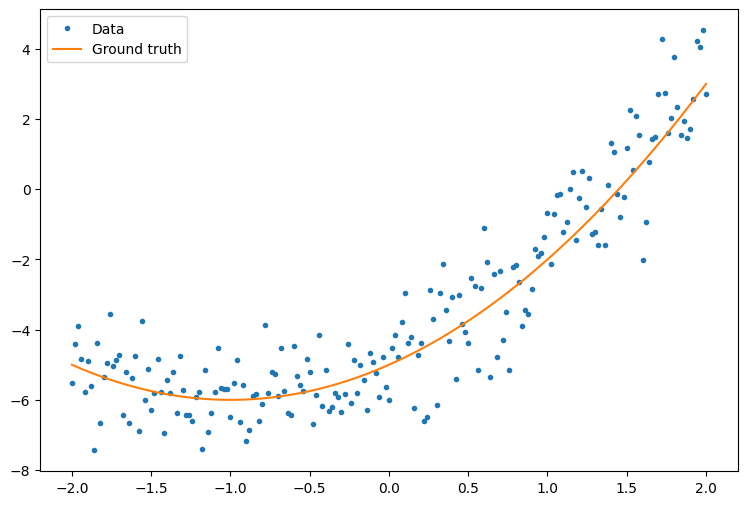

In [47]:
x = tf.linspace(-2, 2, 201)
x = tf.cast(x, tf.float32)

def f(x):
  y = x**2 + 2*x - 5
  return y

y = f(x) + tf.random.normal(shape=[201])

plt.plot(x.numpy(), y.numpy(), '.', label='Data')
plt.plot(x, f(x),  label='Ground truth')
plt.legend();


***Создайте модель:***

In [48]:
class Model(tf.keras.Model):
  def __init__(self, units):
    super().__init__()
    self.dense1 = tf.keras.layers.Dense(units=units,
                                        activation=tf.nn.relu,
                                        kernel_initializer=tf.random.normal,
                                        bias_initializer=tf.random.normal)
    self.dense2 = tf.keras.layers.Dense(1)

  def call(self, x, training=True):
    # For Keras layers/models, implement `call` instead of `__call__`.
    x = x[:, tf.newaxis]
    x = self.dense1(x)
    x = self.dense2(x)
    return tf.squeeze(x, axis=1)


In [49]:
model = Model(64) # число 64 зазвичай вказує на розмірність деякого внутрішнього шару нейронної мережі


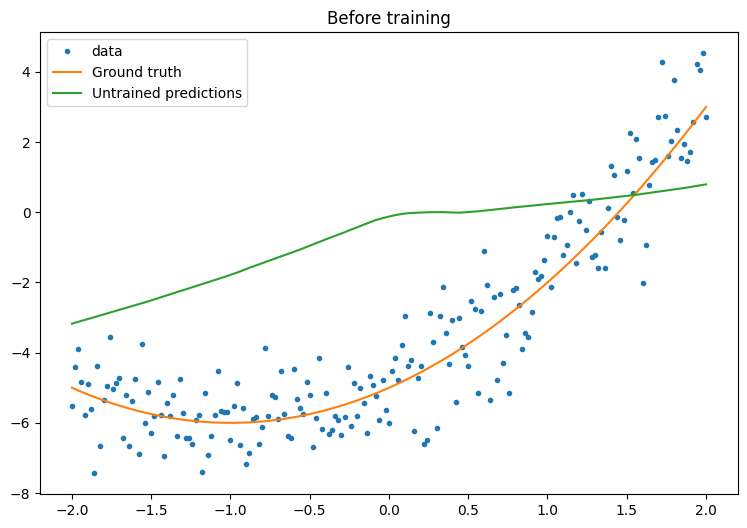

In [50]:
plt.plot(x.numpy(), y.numpy(), '.', label='data')
plt.plot(x, f(x),  label='Ground truth')
plt.plot(x, model(x), label='Untrained predictions')
plt.title('Before training')
plt.legend();


In [51]:
variables = model.variables

optimizer = tf.optimizers.SGD(learning_rate=0.01)

for step in range(1000):
  with tf.GradientTape() as tape:
    prediction = model(x)
    error = (y-prediction)**2
    mean_error = tf.reduce_mean(error)
  gradient = tape.gradient(mean_error, variables)
  optimizer.apply_gradients(zip(gradient, variables))

  if step % 100 == 0:
    print(f'Mean squared error: {mean_error.numpy():0.3f}')


Mean squared error: 12.788
Mean squared error: 0.980
Mean squared error: 0.965
Mean squared error: 0.958
Mean squared error: 0.954
Mean squared error: 0.951
Mean squared error: 0.949
Mean squared error: 0.947
Mean squared error: 0.945
Mean squared error: 0.944


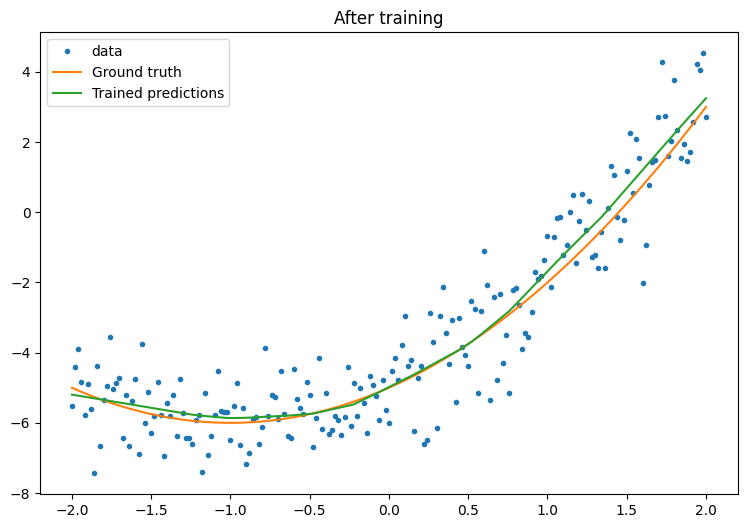

In [52]:
plt.plot(x.numpy(),y.numpy(), '.', label="data")
plt.plot(x, f(x),  label='Ground truth')
plt.plot(x, model(x), label='Trained predictions')
plt.title('After training')
plt.legend();


In [53]:
new_model = Model(64)


In [54]:
new_model.compile(
    loss=tf.keras.losses.MSE,
    optimizer=tf.optimizers.SGD(learning_rate=0.01))

history = new_model.fit(x, y,
                        epochs=100,
                        batch_size=32,
                        verbose=0)

model.save('my_model.keras')

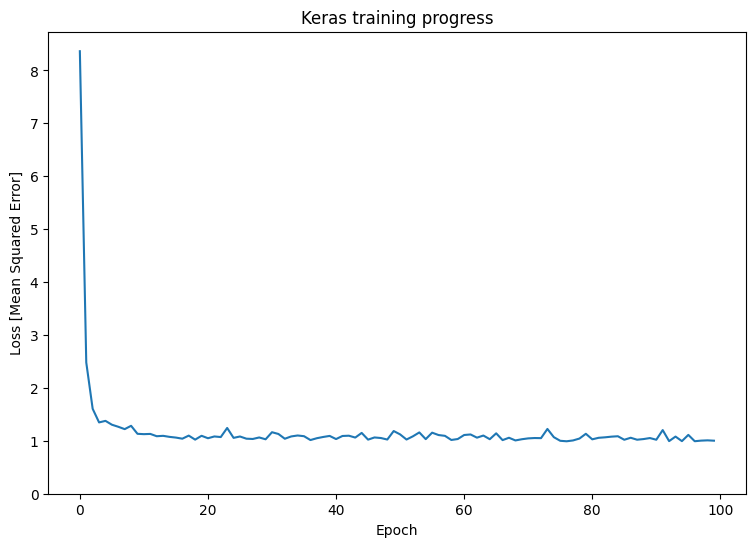

In [55]:
plt.plot(history.history['loss'])
plt.xlabel('Epoch')
plt.ylim([0, max(plt.ylim())])
plt.ylabel('Loss [Mean Squared Error]')
plt.title('Keras training progress');


# **Keras**

In [56]:
from tensorflow import keras


***Скористаємося датасетом imdb і побудуємо нейромережу, яка віднесе рецензію на фільм або до класу негативних, або позитивних рецензій. Для початку вивчимо глибше сам датасет:***



In [57]:
from keras.datasets import imdb

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)


17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [58]:
print(train_data[0])
[1, 14, 22, 16, ..., 178, 32]


[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]


[1, 14, 22, 16, Ellipsis, 178, 32]

***Для того, щоб подивитися безпосередньо на текст рецензії, можна виконати наступний код:***

In [59]:
word_index = imdb.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
decoded_review = ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data[10]])
print(decoded_review)


1641221/1641221 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
? french horror cinema has seen something of a revival over the last couple of years with great films such as inside and ? romance ? on to the scene ? ? the revival just slightly but stands head and shoulders over most modern horror titles and is surely one of the best french horror films ever made ? was obviously shot on a low budget but this is made up for in far more ways than one by the originality of the film and this in turn is ? by the excellent writing and acting that ensure the film is a winner the plot focuses on two main ideas prison and black magic the central character is a man named ? sent to prison for fraud he is put in a cell with three others the quietly insane ? body building ? marcus and his retarded boyfriend daisy after a short while in the cell together they stumble upon a hiding place in the wall that contains an old ? after ? part of it they soon realise its magical powers and realise they may be able to use it t

**Проаналізуємо форму тренувальних даних. Виконаємо наступний код:**



In [60]:
print(train_data.shape)
print(type(train_data[0]))
print(len(train_data[0]))


(25000,)
<class 'list'>
218


In [61]:
import numpy as np


def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.0
    return results

x_train = vectorize_sequences(train_data)
y_train = np.asarray(train_labels).astype('float32')

x_test = vectorize_sequences(test_data)
y_test = np.asarray(test_labels).astype('float32')


In [62]:
print(x_train.shape)


(25000, 10000)


***Тепер визначимо архітектуру. Нехай нейромережа складається з 3 шарів:***

Вхідний шар, що складається з 16 нейронів, який перетворює 10000-елементний вектор на 16-елементний вектор. В якості активаційної функції будемо використовувати ReLU.

Прихований шар, що складається з 16 нейронів, який перетворює 16-елементний вектор на 1-елементний вектор. В якості активаційної функції також використовуватимемо ReLU.

Вихідний шар, що складається з одного нейрона із сигмоїдальною активаційною функцією.

In [63]:
from keras.models import Sequential
from keras.layers import Dense


model = Sequential([
    Dense(16, activation='relu', input_shape=(10000,)),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid'),
])



/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


 ***Є альтернативний спосіб створення мережі:

***


In [64]:
# from keras.models import Sequential
# from keras.layers import Dense


# model = Sequential()
# model.add(Dense(16, activation='relu', input_shape=(10000,)))
# model.add(Dense(16, activation='relu'))
# model.add(Dense(1, activation='sigmoid'))


**Перш ніж приступити до навчання, потрібно вказати ще декілька параметрів: функцію помилки, критерій якості та оптимізатор, за допомогою якого буде виконуватися підгонка терезів нейромережі. Усі ці параметри ми можемо взяти з модулів optimizers, losses та metrics, а потім передати в метод model.compile:**

In [65]:
from keras import optimizers
from keras import losses
from keras import metrics

model.compile(
    optimizer='rmsprop',
    loss='binary_crossentropy',
    metrics=['accuracy']
)


За потреби можна подивитися на архітектуру мережі за допомогою методу summary:



In [66]:
model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_9 (Dense)                      │ (None, 16)                  │         160,016 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 16)                  │             272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 160,305 (626.19 KB)

 Trainable params: 160,305 (626.19 KB)

 Non-trainable params: 0 (0.00 B)

Тепер все готово, щоб розпочати навчання нейронної мережі. Для того, щоб виконати пошук оптимальних параметрів мережі потрібно лише викликати метод fit на екземплярі нашої моделі:



In [67]:
x_val = x_train[:10000]
partial_x_train = x_train[10000:]

y_val = y_train[:10000]
partial_y_train = y_train[10000:]

history = model.fit(
    partial_x_train,
    partial_y_train,
    epochs=20,
    batch_size=512,
    validation_data=(x_val, y_val)
)


Epoch 1/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step - accuracy: 0.6837 - loss: 0.5948 - val_accuracy: 0.8582 - val_loss: 0.3959
Epoch 2/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.8972 - loss: 0.3298 - val_accuracy: 0.8754 - val_loss: 0.3183
Epoch 3/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.9257 - loss: 0.2367 - val_accuracy: 0.8859 - val_loss: 0.2866
Epoch 4/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.9395 - loss: 0.1869 - val_accuracy: 0.8751 - val_loss: 0.3030
Epoch 5/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.9496 - loss: 0.1535 - val_accuracy: 0.8869 - val_loss: 0.2865
Epoch 6/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 91ms/step - accuracy: 0.9575 - loss: 0.1373 - val_accuracy: 0.8838 - val_loss: 0.3066
Epoch 7/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.9710 - loss: 0.1067 - val_accuracy: 0.8852 - val_loss: 0.3058
Epoch 8/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.9765 - loss: 0.0895 - val_accuracy: 0.8793 - v

In [68]:
print(history.history.keys())


dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


**loss** - список, в якому зберігається історія змін помилки на навчальних даних залежно від епохи

**val_loss** - список, де зберігається історія змін помилки на тестових даних залежно від епохи

**accuracy** - список, в якому зберігається історія змін точності на навчальних даних залежно від епохи

**val_accuracy** - список, де зберігається історія змін точності на тестових даних залежно від епохи


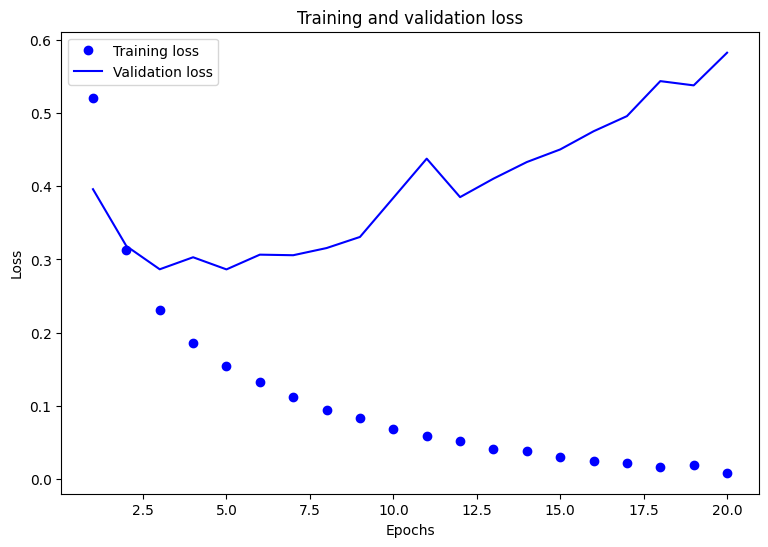

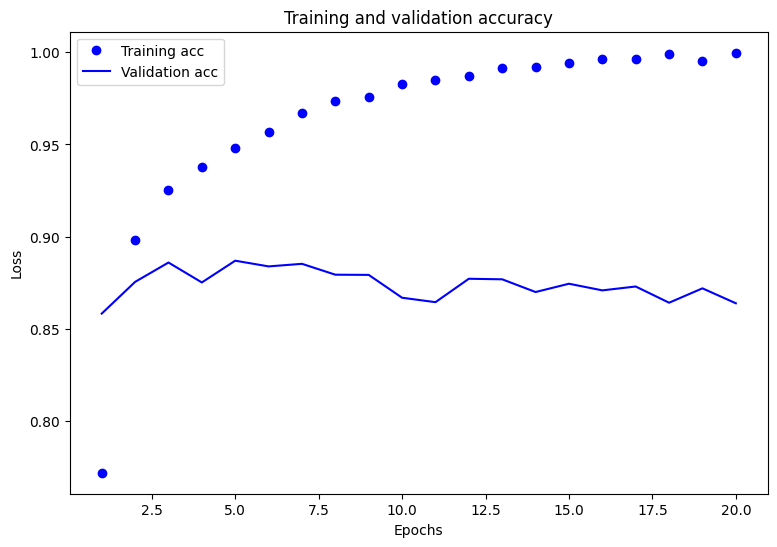

In [69]:
import matplotlib.pyplot as plt


history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(history_dict['accuracy']) + 1)

plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.clf()
val_acc_values = history_dict['val_accuracy']
plt.plot(epochs, history_dict['accuracy'], 'bo', label='Training acc')
plt.plot(epochs, history_dict['val_accuracy'], 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()


Це так само можна побачити обчисливши точність та помилку мережі:

In [70]:
results = model.evaluate(x_test, y_test)
print
(results)


782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8500 - loss: 0.6416


[0.6337379813194275, 0.852400004863739]

In [73]:
model = Sequential()
model.add(Dense(16, activation='relu', input_shape=(10000,)))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(
    optimizer='rmsprop',
    loss='binary_crossentropy',
    metrics=['accuracy']
)
model.fit(x_train, y_train, epochs=4, batch_size=512)
results = model.evaluate(x_test, y_test)
print(results)


Epoch 1/4
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.7243 - loss: 0.5916
Epoch 2/4
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.8958 - loss: 0.3183
Epoch 3/4
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.9149 - loss: 0.2412
Epoch 4/4
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.9317 - loss: 0.1949
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.8864 - loss: 0.2804
[0.2785932421684265, 0.8885599970817566]


In [74]:
results = model.evaluate(x_test, y_test)
print(results)


782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8864 - loss: 0.2804
[0.2785932421684265, 0.8885599970817566]


**для того, щоб використовувати її для класифікації нових даних достатньо скористатися методом predict\**

In [75]:
result = model.predict(x_test[0, :].reshape(1, 10000))
print(result)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
[[0.26458058]]


**Збереження моделі у заданій локалізації:**


In [85]:
model.save('my_model.h5')

In [86]:
new_model = tf.keras.models.load_model("my_model.h5")